<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20LSTM-RF%20for%204%20class%20classifications%20based%20on%20WSNBFSF%20dataset%20ver.3(12212023)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid LSTM-RF for 4 class classifications based on WSNBFSF dataset ver.2**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
#from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
# Load dataset
dataset = pd.read_csv("dataset.csv")
dataset.isnull().sum()

Event             0
Time              0
S_Node            0
Node_id           0
Rest_Energy       0
Trace_Level       0
Mac_Type_Pckt     0
Source_IP_Port    0
Des_IP_Port       0
Packet_Size       0
TTL               0
Hop_Count         0
Broadcast_ID      0
Dest_Node_Num     0
Dest_Seq_Num      0
Src_Node_ID       0
Src_Seq_Num       0
Class             0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312106 entries, 0 to 312105
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event           312106 non-null  int64  
 1   Time            312106 non-null  float64
 2   S_Node          312106 non-null  int64  
 3   Node_id         312106 non-null  int64  
 4   Rest_Energy     312106 non-null  float64
 5   Trace_Level     312106 non-null  int64  
 6   Mac_Type_Pckt   312106 non-null  int64  
 7   Source_IP_Port  312106 non-null  float64
 8   Des_IP_Port     312106 non-null  float64
 9   Packet_Size     312106 non-null  int64  
 10  TTL             312106 non-null  int64  
 11  Hop_Count       312106 non-null  int64  
 12  Broadcast_ID    312106 non-null  int64  
 13  Dest_Node_Num   312106 non-null  int64  
 14  Dest_Seq_Num    312106 non-null  int64  
 15  Src_Node_ID     312106 non-null  int64  
 16  Src_Seq_Num     312106 non-null  int64  
 17  Class     

**Data Preprocessing**

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=4)  # update to 4 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(312106, 17)
(312106, 4)


In [5]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Hybrid LSTM-RF for 4 class Ver.2**

In [7]:
# Train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(4, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

##lstm_model.fit(X_train_lstm, y_train, epochs=15, batch_size=64)
##history = lstm_model.fit(X_train_lstm, y_train, epochs=15, batch_size=64)
history = lstm_model.fit(X_train_lstm, y_train, epochs=15, batch_size=64, validation_data=(X_test_lstm, y_test))

# Extract features from LSTM model
train_lstm_features = lstm_model.predict(X_train_lstm)
test_lstm_features = lstm_model.predict(X_test_lstm)

# Train RF model with LSTM features as input
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_lstm_features, np.argmax(y_train, axis=1))

# Evaluate hybrid model on test set
test_rf_features = rf_model.predict(test_lstm_features)

print(confusion_matrix(np.argmax(y_test, axis=1), test_rf_features))
print(classification_report(np.argmax(y_test, axis=1), test_rf_features))

Epoch 1/15
13143/13143 [==============================] - 112s 8ms/step - loss: 0.2450 - accuracy: 0.9021 - val_loss: 0.1467 - val_accuracy: 0.9345
Epoch 2/15
13143/13143 [==============================] - 104s 8ms/step - loss: 0.1319 - accuracy: 0.9523 - val_loss: 0.1431 - val_accuracy: 0.9441
Epoch 3/15
13143/13143 [==============================] - 104s 8ms/step - loss: 0.1057 - accuracy: 0.9626 - val_loss: 0.0784 - val_accuracy: 0.9697
Epoch 4/15
13143/13143 [==============================] - 104s 8ms/step - loss: 0.0960 - accuracy: 0.9665 - val_loss: 0.0538 - val_accuracy: 0.9824
Epoch 5/15
13143/13143 [==============================] - 104s 8ms/step - loss: 0.0837 - accuracy: 0.9712 - val_loss: 0.0455 - val_accuracy: 0.9851
Epoch 6/15
13143/13143 [==============================] - 104s 8ms/step - loss: 0.0779 - accuracy: 0.9736 - val_loss: 0.0505 - val_accuracy: 0.9831
Epoch 7/15
13143/13143 [==============================] - 105s 8ms/step - loss: 0.0720 - accuracy: 0.9759 - val_

In [8]:
# Calculate confusion matrix and derived metrics
cm = confusion_matrix(np.argmax(y_test, axis=1), test_rf_features)
print("Confusion Matrix:")
print(cm)

# Calculate TP, TN, FP, FN for each class
for i in range(4):  # Assuming 4 classes
    TN, FP, FN, TP = cm[i].ravel()
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    print(f"Class {i}:")
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"False Positive Rate (FPR): {FPR:.4f}")
    print(f"True Positive Rate (TPR): {TPR:.4f}")
    print("-" * 20)

# Calculate overall accuracy, macro-averaged FPR and TPR
accuracy = (cm.diagonal().sum() / cm.sum()) * 100
macro_fpr = np.mean([FP / (FP + TN) for FP, TN in zip(cm.sum(axis=0)[1:], cm.sum(axis=1)[:-1])])
macro_tpr = np.mean([TP / (TP + FN) for TP, FN in zip(cm.diagonal(), cm.sum(axis=1) - cm.diagonal())])
print("Overall Accuracy:", accuracy)
print("Macro-averaged False Positive Rate (FPR):", macro_fpr)
print("Macro-averaged True Positive Rate (TPR):", macro_tpr)

Confusion Matrix:
[[52061   271   168     0]
 [  314 52175     0    65]
 [   33     0 52468    44]
 [    0    73    58 52551]]
Class 0:
True Positives (TP): 0
True Negatives (TN): 52061
False Positives (FP): 271
False Negatives (FN): 168
False Positive Rate (FPR): 0.0052
True Positive Rate (TPR): 0.0000
--------------------
Class 1:
True Positives (TP): 65
True Negatives (TN): 314
False Positives (FP): 52175
False Negatives (FN): 0
False Positive Rate (FPR): 0.9940
True Positive Rate (TPR): 1.0000
--------------------
Class 2:
True Positives (TP): 44
True Negatives (TN): 33
False Positives (FP): 0
False Negatives (FN): 52468
False Positive Rate (FPR): 0.0000
True Positive Rate (TPR): 0.0008
--------------------
Class 3:
True Positives (TP): 52551
True Negatives (TN): 0
False Positives (FP): 73
False Negatives (FN): 58
False Positive Rate (FPR): 1.0000
True Positive Rate (TPR): 0.9989
--------------------
Overall Accuracy: 99.51208145291301
Macro-averaged False Positive Rate (FPR): 0.50

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), test_rf_features)
recall = recall_score(np.argmax(y_test, axis=1), test_rf_features, average='weighted')
precision = precision_score(np.argmax(y_test, axis=1), test_rf_features, average='weighted')
f1score = f1_score(np.argmax(y_test, axis=1), test_rf_features, average='weighted')
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), test_rf_features)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_rf_features)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

Accuracy: 0.99512081452913
Recall: 0.99512081452913
Precision: 0.9951196499763195
F1-Score: 0.9951195037836722
Confusion Matrix:
 [[52061   271   168     0]
 [  314 52175     0    65]
 [   33     0 52468    44]
 [    0    73    58 52551]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     52500
           1       0.99      0.99      0.99     52554
           2       1.00      1.00      1.00     52545
           3       1.00      1.00      1.00     52682

    accuracy                           1.00    210281
   macro avg       1.00      1.00      1.00    210281
weighted avg       1.00      1.00      1.00    210281



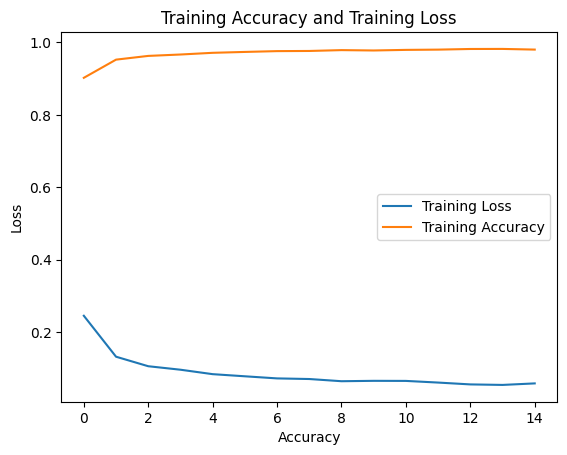

In [10]:
# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy and Training Loss')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()

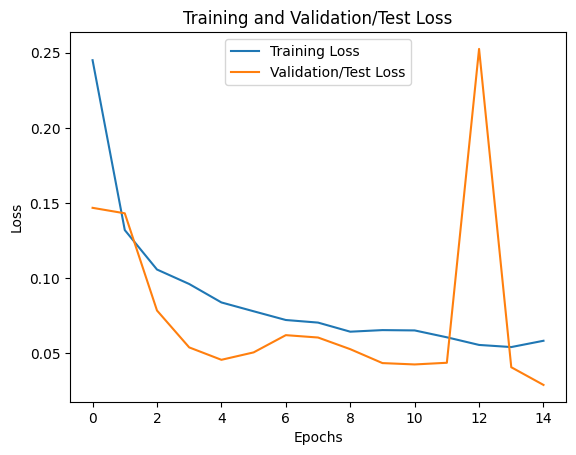

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='gist_earth')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid LSTM-RF Model


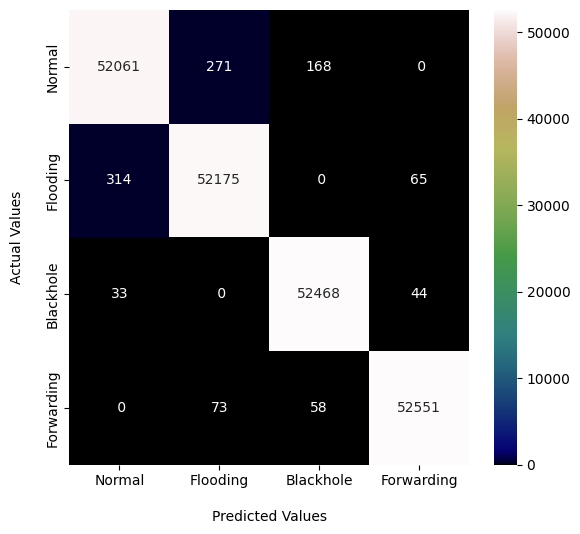

In [13]:
print("Confusion Matrix of Hybrid LSTM-RF Model")
conf_mat(np.argmax(y_test, axis=1), test_rf_features)

In [14]:
report = classification_report(np.argmax(y_test, axis=1), test_rf_features, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates of Hybrid LSTM-RF Model:", detection_rates)

Detection rates of Hybrid LSTM-RF Model: {0: 0.9916380952380952, 1: 0.9927883700574647, 2: 0.9985345893995623, 3: 0.9975133821798717}


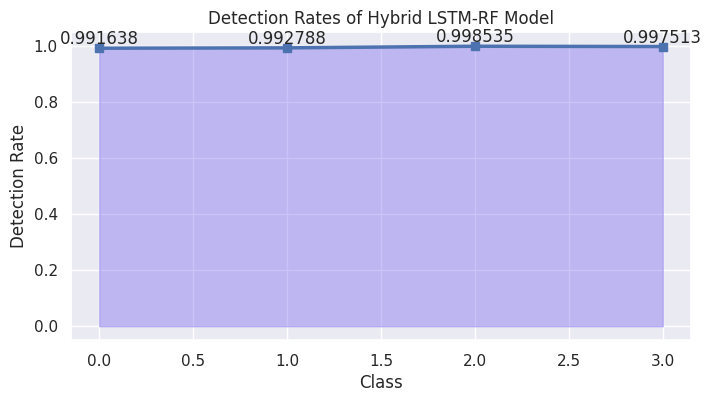

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), test_rf_features, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Extract the class labels and detection rates
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the line graph with filled area and labels
plt.figure(figsize=(8, 4))
plt.plot(labels, rates, marker='s', linestyle='-', linewidth=2.5)
plt.fill_between(labels, rates, color='mediumslateblue', alpha=0.4)

# Add labels to each data point
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.6f}".format(rates[i]), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid LSTM-RF Model')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

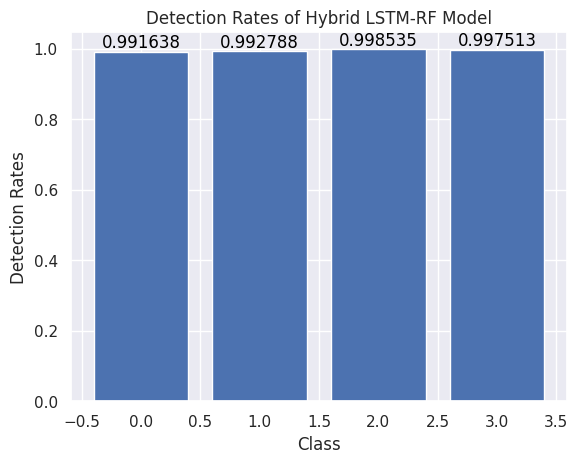

In [16]:
import matplotlib.pyplot as plt

# Extract the labels and rates from the detection rates dictionary
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the bar chart
plt.bar(labels, rates)

# Add labels and units to each bar
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.6f}".format(rates[i]), ha='center', va='bottom', color='black')

# Add axis labels and title
plt.xlabel('Class')
plt.ylabel('Detection Rates')
plt.title('Detection Rates of Hybrid LSTM-RF Model')

# Display the plot
plt.show()

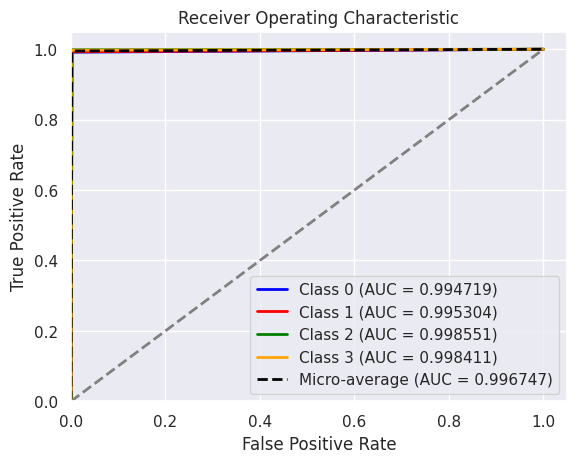

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils

# Convert y_test and test_rf_features to one-hot encoded format
y_test_onehot = np_utils.to_categorical(np.argmax(y_test, axis=1))
test_rf_features_onehot = np_utils.to_categorical(test_rf_features, num_classes=4)  # Convert to one-hot encoded format with 10 classes

# Compute the AUC and ROC curves for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_rf_features_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), test_rf_features_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange']  # Adjust the colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.6f})'.format(i, roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='Micro-average (AUC = {0:0.6f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix and classification report
##print(confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))
##print(classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))